In [31]:
import numpy as np
import pysindy as ps
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [32]:
def bio(data, t):
    F = 5
    B = 1
    R = 1
    
    n = len(data)
    result = np.empty(n)
    
    for i in range(0,n):
        sigma = 0
        for j in range (0,n):
            sigma = sigma + R*(adjacency[i,j])*data[i]*data[j]
        result[i] = F - B*data[i] - sigma
    
    return result

In [33]:
library_functions = [
    lambda : 1,
    lambda x : x,
    lambda x,y : x*y
]
library_function_names = [
    lambda : 1,
    lambda x : x,
    lambda x,y : '' + x + '.' + y
]

"""
input:
    an array with len=number_of_nodes
output: 
    and array with len=len(custom_library.get_feature_names())
example:
    input = [0., 0., 1., 1,]
    output = [1, data[0], data[1], data[2], data[3], 
            data[0]*data[1], data[0]*data[2], data[0]*data[3],
            data[1]*data[2], data[1]*data[3], data[2]*data[3]]
"""
def library_parser(data):
    n = len(data)
    result = [None] * int(1 + n + n*(n-1)/2)
    result[0] = 1
    for i in range(0,n):
        result[i+1] = data[i]
    index = 0
    for i in range(0,n):
        for j in range(i+1,n):
            index += 1
            result[n+index] = data[i]*data[j]
    return result

In [34]:
number_of_nodes = 4
adjacency = np.array([
       [0., 0., 1., 1,],
       [0., 0., 1., 0.],
       [1., 1., 0., 0.],
       [1., 0., 0., 0.]
])

dt = .01

t_train = np.arange(0, 100, dt)
x0_train = [-8, 8, 27, 5]
x_train = odeint(bio, x0_train, t_train)

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.493 x0 + 2.297 x1 + 1.082 x3 + 1.260 x0.x1 + -1.772 x0.x2 + 2.456 x0.x3 + -0.892 x1.x3
x1' = 5.992 1 + -2.074 x0 + -0.316 x3 + -0.255 x0.x1 + 0.223 x0.x2 + -0.961 x1.x2
x2' = -24.918 1 + -6.504 x0 + 6.855 x1 + -1.449 x2 + 6.346 x3 + 1.071 x0.x1 + -1.717 x0.x2 + 3.950 x0.x3 + -0.916 x1.x2 + -1.089 x1.x3
x3' = 0.552 x0.x1 + -0.501 x0.x2 + 0.465 x0.x3 + -0.368 x1.x3


In [35]:
def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return state

real_steady_state = find_steady_state(x_train)        
        
def bio_sindy(data, t):
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

coefficients = model.coefficients()
x_test = odeint(bio_sindy, x0_train, t_train)
sindy_steady_state = find_steady_state(x_test)

print('real_steady_state:', real_steady_state)
print('sindy_steady_state:', sindy_steady_state)

real_steady_state: [1.11168052 2.35265739 1.12104436 2.37247365]
sindy_steady_state: [1.11228059 2.35580021 1.11974547 2.36967157]


In [36]:
perturbation = np.array([1., 0., 0., 1.])
perturbed = np.add(sindy_steady_state, perturbation)

t_perturbed = np.arange(0, 10, dt)
x_perturbed = odeint(bio_sindy, perturbed, t_perturbed)
perturbed_steady_state = find_steady_state(x_perturbed)

print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: [1.1122507  2.35573156 1.1197743  2.36973726]


In [37]:
def flow(X):
    prev_state = X[0]
    result = np.empty((0,len(prev_state)))
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, diff))
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return result

x_flow = flow(x_perturbed)
x_flow

array([[ 1.20735363e-02, -2.86394990e-02,  1.51243419e-01,
         1.87998473e-02],
       [ 6.69159450e-03, -3.09832146e-02,  1.42250676e-01,
         1.74931303e-02],
       [ 1.55793491e-03, -3.29128108e-02,  1.33344228e-01,
         1.61600291e-02],
       ...,
       [ 5.72369119e-05,  9.81677146e-05, -4.95361518e-05,
        -1.02530488e-04],
       [ 5.64780420e-05,  9.67762230e-05, -4.88523572e-05,
        -1.01105181e-04],
       [ 5.57286834e-05,  9.54041838e-05, -4.81779135e-05,
        -9.96992632e-05]])

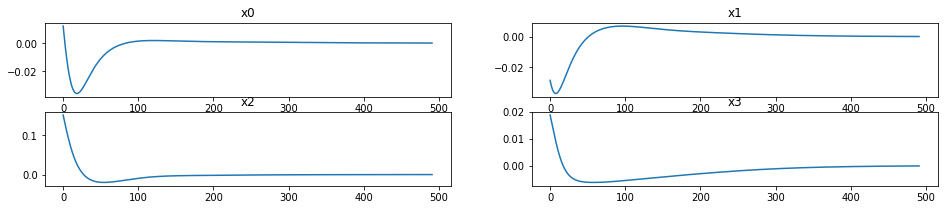

In [55]:
fpr = 2
plt.rcParams["figure.figsize"] = (16, 3)
fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
plt.figure(1)
for i in range(0,number_of_nodes):
    axs[int(i/fpr), i%fpr].plot(x_flow[:,i])
    axs[int(i/fpr), i%fpr].set_title('x'+str(i))

plt.show()